# State space models and demystifying the Kalman filter

> Joris de Wind (1:1 Analytics, DBNL)

## Terminology

- State space models?
- Demystifying the Kalman filter

> You might have never heard of state space models & the Kalman filter is infamous for being complicated yet very important

However, the basics are very intuitive!

## Application domains and examples

- Guidance, navigation and control (e.g. autopilot, rockets, missiles, self-driving cars, etc.)
- Time series econometrics (e.g. lots of applications in finance and economic forecasting)
- Etc.

<img src="rocket_icon.png" alt="Rocket" width="200"/>

## When do we need state space models and the Kalman filter?

- State space representation: very useful for time series processes with latent variables or noisy measurements
- You **need** the Kalman filter to work with state space models

### Latent variables

- Underlying state of the economy, e.g. productivity
- Fundamental value of a stock index

### Noisy measurents

- Measurement errors in sensors like inertial measurement unit, odometer, GPS, etc.
- Data revisions by statistical offices

## Example: let’s pretend that we are rocket scientists

> https://lectures.quantecon.org/py/kalman.html

- Let $x \in R^2$ denote the current location of a missile, a latitude-longitute pair
- But we don't know its exact location ... we only have a rough idea based on previous measurements, $x \sim N(\hat{x}, \Sigma)$

In [1]:
# imports
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
from matplotlib.mlab import bivariate_normal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# prior based on previous measurements
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T

# grid for latitude-longitute pair
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)

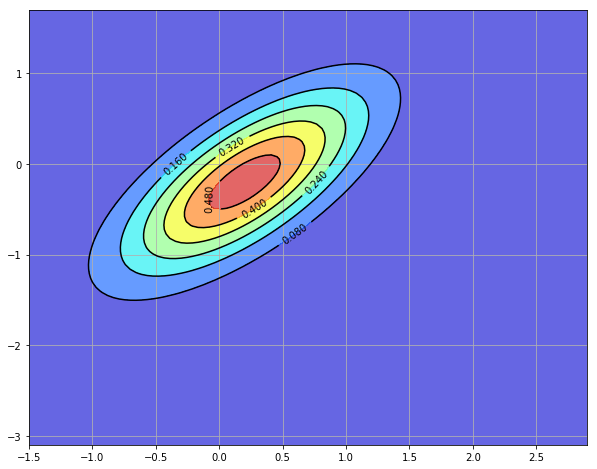

In [3]:
def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y, s_xy = np.sqrt(C[0, 0]), np.sqrt(C[1, 1]), C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

Z = gen_gaussian_plot_vals(x_hat, Σ)

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
plt.show()

### The filtering step

- The missile has been located by our sensors, which report that the current location is $y=(2.3, −1.9)$

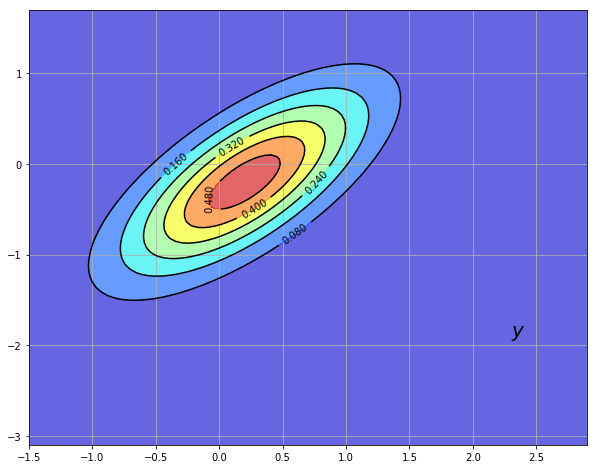

In [4]:
y = np.matrix([2.3, -1.9]).T

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")
plt.show()

#### Meaurement error

Our sensors are imprecise and we have the following measurement equation:

> $y = Gx + v$ with $v \sim N(0, R)$

How should we combine our prior based on previous measurements with the new measurement?

#### Bayes' theorem

> $p(x|y) = \frac{p(y|x) p(x)}{p(y)}$

- $p(x) = N(\hat{x}, \Sigma)$
- $p(y|x) = N(Gx, R)$
- $p(y)$ is constant

#### Combining two Gaussians

Just another Gaussian!

> $p(x|y) = N(\hat{x}^F, \Sigma^F)$

with

- $\hat{x}^F = \hat{x} + \Sigma G' (G \Sigma G' + R)^{-1} (y - G \hat{x})$
- $\Sigma^F = \Sigma - \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma$

Pro tip: the well-known matching coefficients trick makes the algebra relatively straightforward

In [5]:
# measurement equation
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ

# filtering step
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ

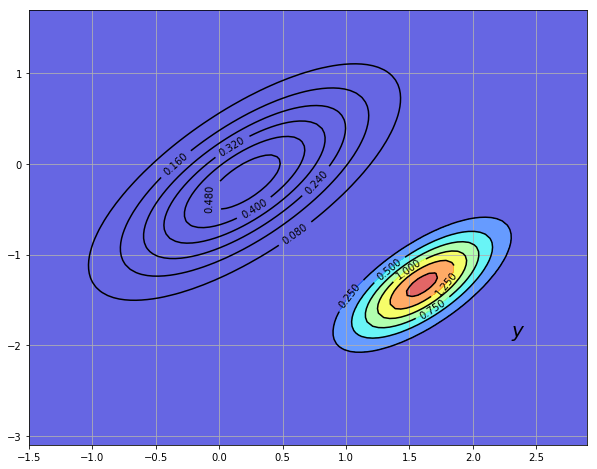

In [6]:
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")
plt.show()

#### Filtering terminology

The previous calculations are referred to as the filtering step, as its goal is to filter out the noise

<img src="kalman_coffee_filter.png" alt="filter" width="200"/>

### The prediction step

We know that the missile is moving ... So, if we want to forecast the location after one unit of time we need to be aware of its law of motion as well (i.e. the state equation):

> $x_{t+1} = Ax_t + w_{t+1}$ with $w_t \sim N(0, Q)$

Given $x_t \sim N(\hat{x}^F, \Sigma^F)$ we simply get that

> $x_{t+1} \sim N(A\hat{x}^F, A \Sigma^F A' + Q)$

and of course we can substitute the expressions for $\hat{x}^F$ and $\Sigma^F$

> $\hat{x}_{new} = A \hat{x}^F = A \hat{x} + A \Sigma G' (G \Sigma G' + R)^{-1} (y - G \hat{x})$
> $\Sigma_{new} = A \Sigma^F A' + Q = A \Sigma A' - A \Sigma G' (G \Sigma G' + R)^{-1} G \Sigma A' + Q$

### Kalman gain and prediction error

Normally we rewrite the system as:

> $\hat{x}_{new} = A \hat{x} + K v$

> $\Sigma_{new} = A \Sigma A' - K G \Sigma A' + Q$

with

- $K = A \Sigma G' (G \Sigma G' + R)^{-1}$
- $v = y - G \hat{x}$

In [7]:
# state equation
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.3 * Σ

# prediction step
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)

In [8]:
# Density 1 (prior)
Z = gen_gaussian_plot_vals(x_hat, Σ)

# Density 2 (filtering)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)

# Density 3 (prediction)
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)

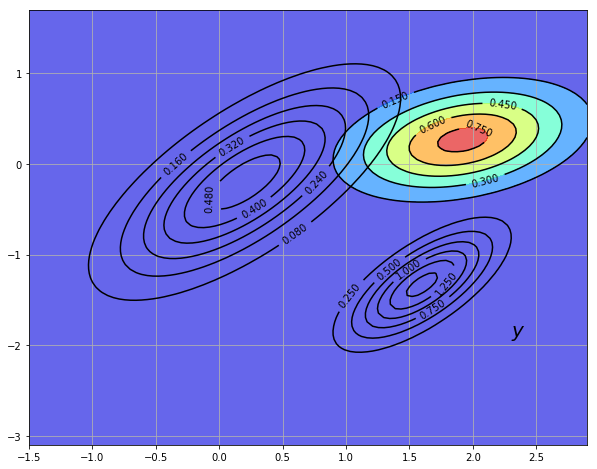

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")
plt.show()

## Wrap-up

- You basically need to repeat the procedure after every new measurement
- Kalman smoother
- Maximum likelihood
- Nonlinear and non-Gaussian systems

## Python

All the above was basically calculating the Kalman by hand, but there are packages as well:

- quantecon
- filterpy
- pykalman

## Example of state space representation

LLM (a.k.a. the "Hello world" of state space models):

> $y_t = m_t + \varepsilon_t$ with $\varepsilon_t \sim N(0, \sigma_{\varepsilon}^{2})$

> $m_t = m_{t-1} + \upsilon_t$ with $\upsilon_t \sim N(0, \sigma_{\upsilon}^{2})$

> $m_0 \sim N(a, P)$

- We observe the data (y), but *not* the underlying state (m)
- There are both shocks with temporary effects (e) as well as structural shocks with permanent effects (u)